In [1]:
import sys
import os
import time
from pathlib import Path
import csv
from math import *
import numpy as np
import matplotlib.pyplot as plt
import cv2

from utils import get_abs_path

In [2]:
def cv2_imshow(img):
    img = np.concatenate((img[:,:,2:3], img[:,:,1:2], img[:,:,0:1]), axis=2)
    plt.imshow(img)
    plt.show()


def rand_point_on_map(map_size, offset):

    min_pos = offset
    max_x_pos = map_size[0]-offset
    max_y_pos = map_size[1]-offset

    x_pos = np.random.randint(low = min_pos, high = max_x_pos, size = 1)
    y_pos = np.random.randint(low = min_pos, high = max_y_pos, size = 1)
    return int(x_pos), int(y_pos)


def create_start_point(img, map_size, offset=3):

    x_pos, y_pos = rand_point_on_map(map_size, offset)

    occupied_pos = 255
    while img[y_pos,x_pos,0] == occupied_pos:
        x_pos, y_pos = rand_point_on_map(map_size, offset)

    cv2.rectangle(img, (x_pos-2, y_pos-2), (x_pos+2, y_pos+2), (0,255,0), -1)
    return x_pos, y_pos


def create_end_point(img, start_x_pos, start_y_pos, map_size, min_distance, offset=3):

    x_pos, y_pos = rand_point_on_map(map_size, offset)
    occupied_pos = 255
    while True:
        x_pos, y_pos = rand_point_on_map(map_size, offset)

        if img[y_pos,x_pos,0] != occupied_pos:
            if sqrt( pow(start_x_pos-x_pos,2) + pow(start_y_pos-y_pos,2) ) > float(min_distance):
                break

    cv2.rectangle(img, (x_pos-2, y_pos-2), (x_pos+2, y_pos+2), (0,255,0), -1)
    return x_pos, y_pos


def create_rect(img, x_pos, y_pos, width, height):
    x_pos, y_pos, width, height = int(x_pos), int(y_pos), int(width), int(height)
    cv2.rectangle(img, (x_pos, y_pos), (x_pos+width, y_pos+height), (255,0,0), -1)


def add_obstacles(img, rect_count, rect_min, rect_max):
    for i in range(rect_count):
        rect_width = np.random.randint(low = rect_min, high = rect_max, size = 1)
        rect_heigth = np.random.randint(low = rect_min, high = rect_max, size = 1)
        pos = np.random.randint(low = 0, high = map_width-rect_width, size = 4)
        create_rect(img, pos[0], pos[1], rect_width, rect_heigth)

In [3]:
# image size
map_width = 120
map_height = 120
map_size = [map_width, map_height]

# rect settings
rect_count = 5 #12
rect_min = 20 #15
rect_max = 30 #25

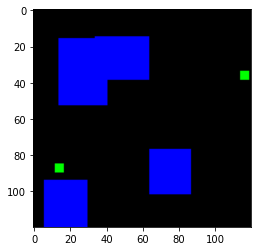

In [4]:
# generate test image
img = np.zeros((map_width, map_height, 3), np.uint8)
add_obstacles(img, rect_count, rect_min, rect_max)

start_x_pos, start_y_pos = create_start_point(img, map_size)
end_x_pos, end_y_pos = create_end_point(img, start_x_pos, start_y_pos, map_size, min_distance=90)
cv2_imshow(img)

In [5]:
# (first_map_num, last_map_num, num_paths)
data_settings = {
    'encoder': (0, 10, 1),
    'train': (0, 10, 2),
    'valid': (0, 10, 2),
    'test':  (0, 10, 2)
}
project_path = get_abs_path(1)
results_path = project_path + '/data/'
maps_points_filename = 'maps_points.csv'

# remove old point files
# os.remove(results_path+'train/'+maps_points_filename)
# os.remove(results_path+'valid/'+maps_points_filename)
# os.remove(results_path+'test/'+maps_points_filename)

# create dirs
Path(results_path+'encoder_images/').mkdir(parents=True, exist_ok=True)
Path(results_path+'train/maps/').mkdir(parents=True, exist_ok=True)
Path(results_path+'valid/maps/').mkdir(parents=True, exist_ok=True)
Path(results_path+'test/maps/').mkdir(parents=True, exist_ok=True)

In [6]:
def generate_maps(results_path, first_map_num, last_map_num, num_paths):
    for n in range(first_map_num, last_map_num):
        # generate image
        image = np.zeros((map_width, map_height, 3), np.uint8)

        # add obstacles
        add_obstacles(image, rect_count, rect_min, rect_max)

        for i in range(num_paths):
            # create start and end points
            img = np.copy(image)
            start_x_pos, start_y_pos = create_start_point(img, map_size)
            end_x_pos, end_y_pos = create_end_point(img, start_x_pos, start_y_pos, map_size, min_distance=65)

            # create map
            map_name = 'map_' + str(n) + '_' + str(i) + '.png'
            map_data = [map_name, str(start_x_pos), str(start_y_pos), str(end_x_pos), str(end_y_pos)]

            # save points to csv
            # print(map_data)
            with open(results_path + maps_points_filename, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerows([map_data])

            # save image
            if not cv2.imwrite(results_path + map_name, img):
                raise Exception('Could not write image')


generate_maps(results_path+'encoder_images/',  *data_settings['encoder'])
generate_maps(results_path+'train/maps/', *data_settings['train'])
generate_maps(results_path+'valid/maps/', *data_settings['valid'])
generate_maps(results_path+'test/maps/',  *data_settings['test'])